# 1. Setup

## 1.1 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.2 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.3 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/47442dd8-dff8-11ee-93c1-ee8f99abc9e9.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(1)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[400:400+250,500:500+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

2024-03-11 15:28:48.777 python[29997:294439] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [11]:
# plt.imshow(frame[400:400+250,500:500+250, :])

# 2.Data Augmentation

In [29]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        
        data.append(img)
    
    return data

In [30]:
import os
import uuid

In [27]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [35]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    img = data_aug(img)

    # Convert the OpenCV image to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.uint8)
    
    # Apply the data augmentation
    augmented_img_tensor = data_aug(img_tensor)
    
    # Convert the augmented tensor back to a NumPy array for writing to file
    augmented_img = augmented_img_tensor.numpy()
    
    # Now you can write the augmented images to file
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), augmented_img)

In [36]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [37]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [38]:
dir_test = anchor.as_numpy_iterator()

In [39]:
print(dir_test.next())

b'data/anchor/4f976fca-dff5-11ee-b86e-ee8f99abc9e9.jpg'


## 3.2 Preprocessing - Scale and Resize

In [40]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [43]:
img = preprocess('data/anchor/03418390-dff5-11ee-b86e-ee8f99abc9e9.jpg')

In [44]:
img.numpy().max() 

0.9882353

In [46]:
# dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [47]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [48]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [49]:
samples = data.as_numpy_iterator()

In [50]:
exampple = samples.next()

In [51]:
exampple

(b'data/anchor/6e941e32-dff5-11ee-b86e-ee8f99abc9e9.jpg',
 b'data/positive/a508db12-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [52]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [53]:
res = preprocess_twin(*exampple)

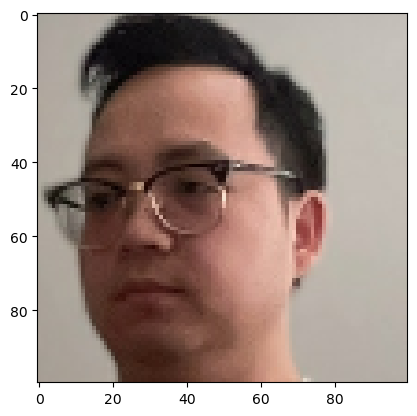

In [58]:
plt.imshow(res[1])

In [56]:
res[2]

1.0

In [59]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [60]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [61]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [73]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [74]:
embedding = make_embedding()

In [75]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [76]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [77]:
l1 = L1Dist()

In [80]:
# l1(input_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [89]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [90]:
siamese_model = make_siamese_model()

In [91]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [92]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [93]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [94]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [95]:
test_batch = train_data.as_numpy_iterator()

In [96]:
batch_1 = test_batch.next()

In [97]:
X = batch_1[:2]

In [98]:
y = batch_1[2]

In [99]:
y

array([0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

In [101]:
# tf.losses.BinaryCrossentropy??

In [102]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [103]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [104]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [105]:
EPOCHS = 50

In [106]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2024-03-12 18:10:14.862976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-12 18:10:14.932636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1/1 [==============================] - 0s 123ms/step


2024-03-12 18:10:21.087440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/27 [===========================>..] - ETA: 2sTensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2024-03-12 18:11:14.968869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-12 18:11:15.011065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


27/27 [==============================] - 65s 2s/step
0.67206466 0.4097561 0.95454544

 Epoch 2/50
27/27 [==============================] - 55s 2s/step
0.041538037 0.9342723 0.9660194

 Epoch 3/50
27/27 [==============================] - 56s 2s/step
0.035664726 0.96634614 0.99014777

 Epoch 4/50
27/27 [==============================] - 56s 2s/step
0.10294919 0.98536587 1.0

 Epoch 5/50
27/27 [==============================] - 56s 2s/step
0.13601504 0.9858491 0.99523807

 Epoch 6/50
27/27 [==============================] - 56s 2s/step
0.0001486035 0.98067635 1.0

 Epoch 7/50
27/27 [==============================] - 56s 2s/step
0.011742304 0.9951456 1.0

 Epoch 8/50
27/27 [==============================] - 56s 2s/step
0.028249213 0.99523807 1.0

 Epoch 9/50
27/27 [==============================] - 57s 2s/step
0.27806282 0.9954751 0.98214287

 Epoch 10/50
27/27 [==============================] - 56s 2s/step
0.005139239 0.9714286 0.99029124

 Epoch 11/50
27/27 [=============================

# 6. Evaluate Model

## 6.1 Import Metrics

In [107]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [108]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [109]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 83ms/step


In [110]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]

In [111]:
y_true

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [112]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [113]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [114]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 34ms/step
1.0 1.0


## 6.4 Viz Results

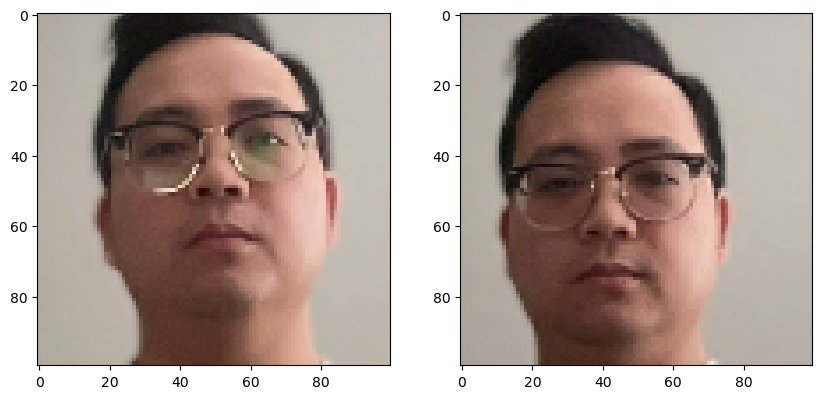

In [115]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [116]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

/Users/vinhduyle/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [117]:
L1Dist

__main__.L1Dist

In [118]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [119]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 270ms/step


2024-03-12 19:28:05.760676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[9.9999332e-01],
       [1.3442287e-11],
       [9.9997878e-01],
       [8.2390605e-12]], dtype=float32)

In [120]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
application_data/verification_images

In [127]:
os.listdir(os.path.join('application_data', 'verification_images'))

['1d977850-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '22001000-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '47056968-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 'b079597c-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '41e05dda-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '5d4cca36-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 'b05d9150-dff4-11ee-b86e-ee8f99abc9e9.jpg',
 '5cb4d618-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '4661f2ec-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 'b2940a0e-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '1d5a0f92-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '1c6b02a8-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '3b51ec54-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '56f72028-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 'b2b15432-dff4-11ee-b86e-ee8f99abc9e9.jpg',
 '54ebdb20-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '1f14651c-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '56088bf2-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '207345cc-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '380b409a-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 '25bb68de-dff3-11ee-b86e-ee8f99abc9e9.jpg',
 'b21313d0-dff4-11ee-b86e-ee8f99abc9e9.jpg',
 '5354c0ba

In [128]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [129]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/1d977850-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/22001000-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/47056968-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/b079597c-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/41e05dda-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/5d4cca36-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/b05d9150-dff4-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/5cb4d618-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/4661f2ec-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/b2940a0e-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/1d5a0f92-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/1c6b02a8-dff3-11ee-b86e-ee8f99abc9e9.jpg
application_data/verification_images/3b51ec54-dff3-11ee-b86e-ee8

In [130]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [133]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[400:400+250,500:500+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 10ms/step
True
1/1 [==============================] - 0s 13ms/step
True
1/1 [==============================] - 0s 11ms/step
True


In [134]:
np.sum(np.squeeze(results) > 0.9)

23

In [135]:
results

[array([[0.99499136]], dtype=float32),
 array([[0.74779785]], dtype=float32),
 array([[0.8020811]], dtype=float32),
 array([[0.9744757]], dtype=float32),
 array([[0.11503232]], dtype=float32),
 array([[0.99954754]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999795]], dtype=float32),
 array([[0.9999131]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.6973581]], dtype=float32),
 array([[0.47633845]], dtype=float32),
 array([[0.653284]], dtype=float32),
 array([[0.10533495]], dtype=float32),
 array([[0.19275762]], dtype=float32),
 array([[0.7560482]], dtype=float32),
 array([[0.46547955]], dtype=float32),
 array([[0.15759034]], dtype=float32),
 array([[0.09093843]], dtype=float32),
 array([[0.29221523]], dtype=float32),
 array([[0.78450114]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.09129864]], dtype=float32),
 array([[0.9809542]], dtype=float32),
 array([[0.9909338]], dtype=float32),
 array([[0.23794426]], dtype=float32),
 array([[0.47062004]